# II. Time Series Models: Theory and Foundations


## II.1. Introduction

### II.1.A. What's forecasting about?

Forecasting involves the prediction of some future event.

Forecasting problems are commonly classified based on the time horizon of the prediction:

-   **Short-term forecasting**: This involves predictions a few time periods (days, weeks, or months) into the future.

-   **Medium-term forecasting**: This type of forecasting typically covers a horizon from one to two years into the future.

-   **Long-term forecasting**: Long-term forecasting extends to predictions many years into the future.

Short-term and medium-term forecasting are typically based on identifying, modeling, and extrapolating patterns found in historical data.

Long-term forecasting, in contrast, is often based on expert knowledge and fundamental models.


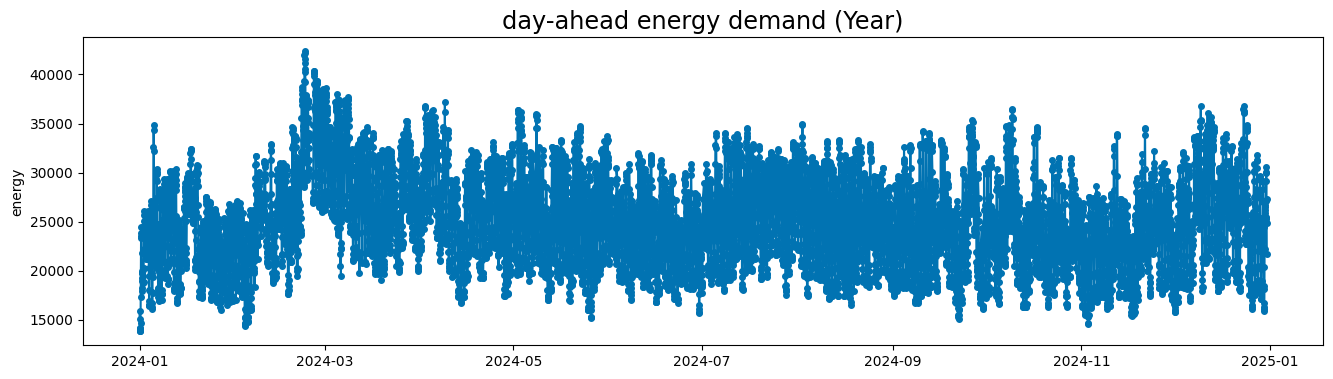

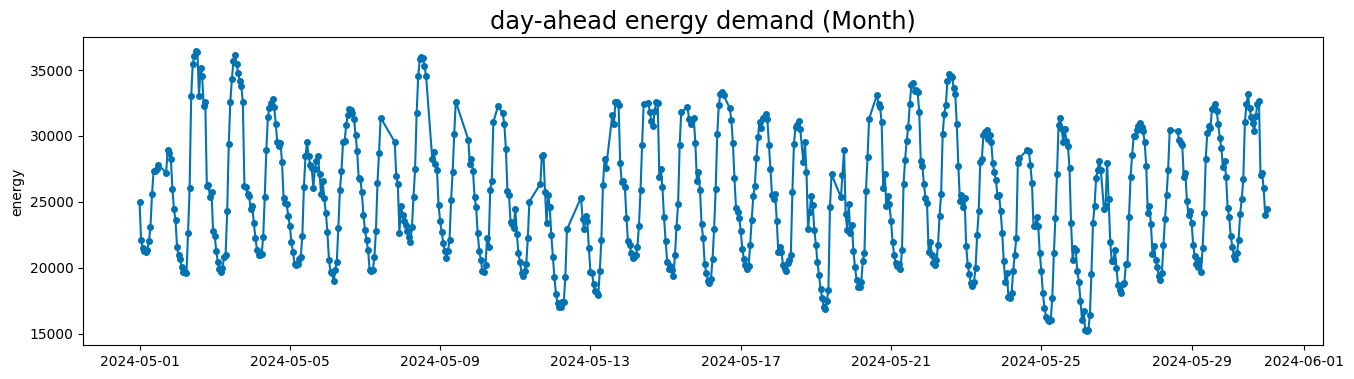

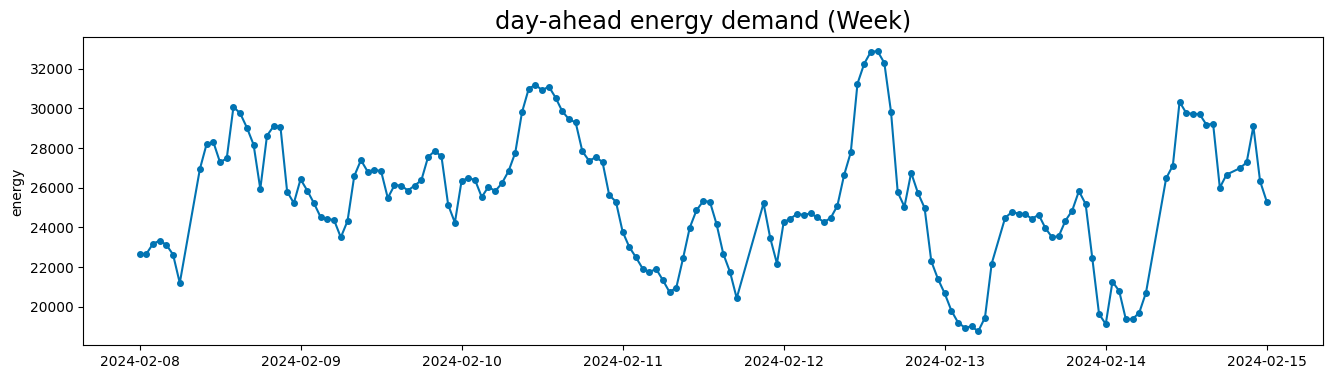

In [1]:
from utils import ExampleDataLoader, plot_series_slice

energy = ExampleDataLoader("energy").load().set_index("datetime")

energy_yr = plot_series_slice(
    energy, 
    start="2024-01-01 00:00:00", 
    stop="2024-12-31 00:00:00",
    freq="h",    
    title="day-ahead energy demand (Year)",
    return_data=True,
)

energy_month = plot_series_slice(
    energy, 
    start="2024-05-01 00:00:00", 
    stop="2024-05-31 00:00:00",
    freq="h",
    title="day-ahead energy demand (Month)",
    return_data=True,
)

energy_week = plot_series_slice(
    energy, 
    start="2024-02-08 00:00:00", 
    stop="2024-02-15 00:00:00",
    freq="h",
    title="day-ahead energy demand (Week)",
    return_data=True,
)

### II.1.B. Objectives of time series analysis & forecasting

- **Describing** the evolution of a time series.

- **Modelling** the process that has generated the time series by means of a suitable statistical model.

- **Forecasting**/Predicting future values of the time series.

- **Control**. Good  forecasts enable the analyst to take actions so as to control a given process.

### II.1.C. Forecasting taxonomy

Forecasting methods can be broadly categorized into two types:

- **Quantitative methods**: These methods are employed when sufficient information about the past is available, typically in the form of numerical time series data. They assume that the future will be similar to the past, a concept known as the continuity assumption.

- **Qualitative methods**: These methods are used when little or no quantitative information is available. They are based on expert knowledge and judgment; a well-known example is the Delphi method.

Quantitative models can be further classified into two main types:

- **Explanatory models**: These models express the variable to be forecast ($y$) as a function of other explanatory variables ($x_1, ..., x_n$) and a noise component.

$$
y = f(x_1, ..., x_n, \text{noise})
$$


- **Time series models**: These models predict the variable to be forecast ($y_t$) as a function of its own past values ($y_{t-1}, y_{t-2}, ...$) and a noise component, or potentially also incorporating explanatory variables.

    $$
    y_t = f(y_{t-1}, y_{t-2}, ..., \text{noise})
    $$

    or

    $$
    y_t = f(y_{t-1}, y_{t-2}, ..., x_t, x_{t-1}, x_{t-2}, ..., \text{noise})
    $$

In both explanatory and time series models, the observation ($y$) is considered to be composed of two components:

$$
\boxed{\quad y = \textbf{pattern} + \textbf{\color{red}{noise}}\quad}
$$


Where:

-   **pattern** = forecast

-   **noise** = uncertainty

The objective of forecasting is to separate these two components: to use the pattern for forecasting and to characterize prediction errors using the observed noise.


### I.1.D. Forecast pipeline

The general steps involved in the forecasting process are:

1.  **Collect Data**: The foundation of any forecasting endeavor is the acquisition of relevant and high-quality historical data. This may involve gathering data from various sources and ensuring its completeness and accuracy.

2.  **Preprocess (Clean) Data**: Time series data often requires careful preprocessing to handle imperfections and inconsistencies.

    -   **Missing Values Imputation**: Gaps in the time series must be addressed. Techniques like linear interpolation, mean/median imputation, or more sophisticated methods based on time series characteristics can be employed.

    -   **Outlier Detection and Treatment**: Extreme values that deviate significantly from the typical pattern can distort forecasts. Identifying and mitigating the impact of outliers through techniques like moving average smoothing or robust statistical methods is essential.

    -   **Data Transformation**: In some cases, transformations such as logarithmic or Box-Cox transformations may be necessary to stabilize the variance or make the time series stationary.

    -   **Scaling**: Scaling the data (e.g., using min-max scaling or standardization) can be beneficial for certain modeling techniques, especially neural networks.

3.  **Feature Engineering (If Applicable)**: Depending on the forecasting model, creating new features from the existing time series can improve predictive performance.

    -   **Lagged Variables**: Including past values of the time series as predictors ($y_{t-1}$, $y_{t-2}$, etc.) is a common and powerful technique.

    -   **Rolling Statistics**: Calculating statistics over moving windows (e.g., rolling mean, rolling standard deviation) can capture local trends and variability.

    -   **Time-Based Features**: Extracting features related to time (e.g., day of the week, month of the year) can help capture seasonality.

4.  **Choose Model**: Selecting an appropriate forecasting model is critical and depends on the characteristics of the data and the forecasting task.

    -   Consider factors such as the presence of trends, seasonality, autocorrelation, and the desired forecast horizon.

    -   Evaluate a range of models, from simple methods like those discussed earlier (average, naive, seasonal naive, drift) to more complex approaches like ARIMA, exponential smoothing, or machine learning models.

5.  **Model Selection and Evaluation**: Rigorous model selection and evaluation are essential to ensure the chosen model generalizes well to unseen data.

    -   **Time Series Cross-Validation**: Unlike traditional cross-validation, time series cross-validation respects the temporal order of the data. Techniques like rolling-origin cross-validation are used to simulate forecasting at different points in time.

    -   **Evaluation Metrics**: Assess model performance using appropriate metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), or Mean Absolute Percentage Error (MAPE).

    -   **Statistical Significance Tests**: When comparing multiple models, statistical tests can help determine if the differences in performance are statistically significant.

6.  **Fit Parameters**: Once a model is selected, its parameters must be estimated using the training data.

    -   This often involves optimization techniques to minimize the chosen error metric.

7.  **Model Validation**: After training, it's crucial to validate the model on a separate validation set to ensure it generalizes well and is not overfitting.

8.  **Forecasting**: With a validated model, forecasts can be generated for the desired future time periods.

9.  **Uncertainty Estimation**: Providing forecasts without an estimate of their uncertainty can be misleading.

    -   Techniques like prediction intervals, bootstrapping, or simulation can be used to quantify the range of possible future outcomes.

10. **Monitoring and Model Updating**: Forecasting models should be continuously monitored and updated as new data becomes available.

    -   The performance of the model may degrade over time due to changes in the underlying patterns of the time series.



## II.2. Naïve forecasters

We introduce some basic, yet important, forecasting methods.

In [2]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.datasets import load_airline

#### II.2.A. Average method

The average method forecasts all future values as the mean of the historical data.

$$
\hat{y}_t = \bar{y} = \frac{1}{T} \sum_{t=1}^{T} y_t
$$

where $\hat{y}_t$ is the forecast at time $t$, $\bar{y}$ is the mean of the historical data, and $T$ is the number of historical data points.

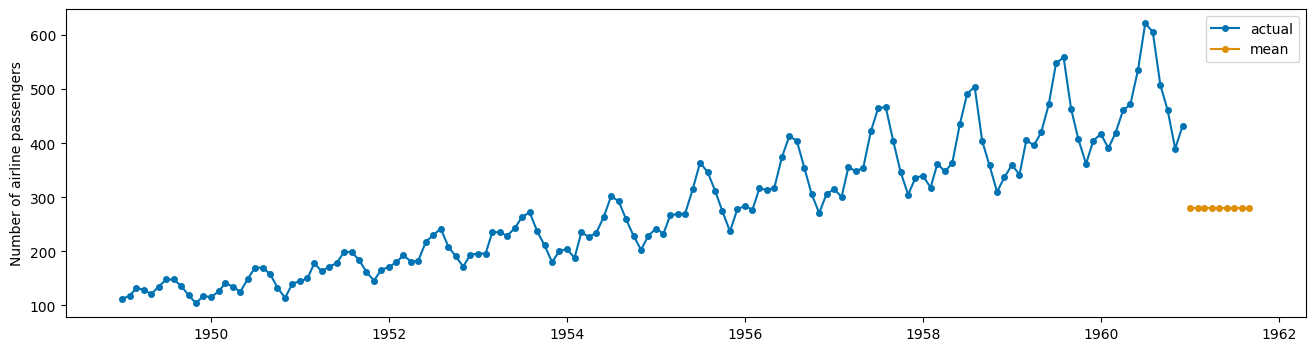

In [3]:
y = load_airline()

forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_mean_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_mean_pred, labels=["actual", "mean"])

### II.2.B. Naïve method

The naive forecaster predicts the next value to be equal to the last observed value.

$$
\hat{y}_{t} = y_{t-1}
$$

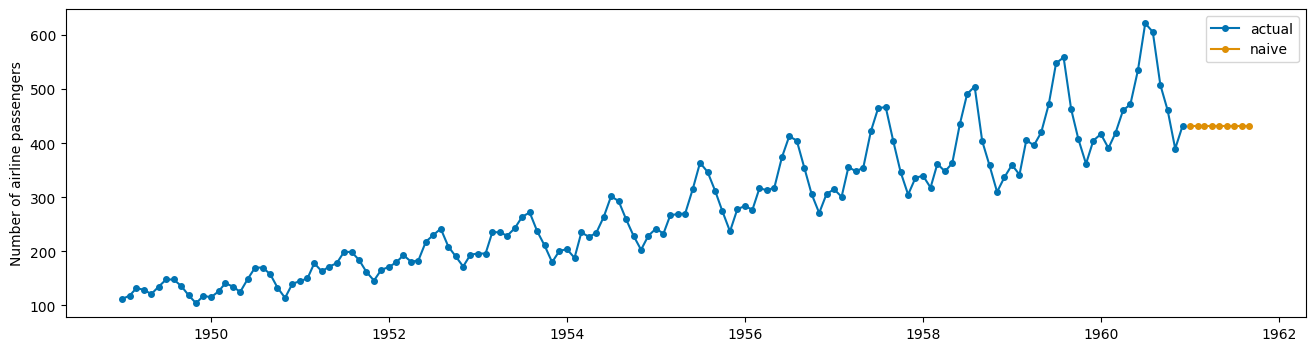

In [4]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_naive_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_naive_pred, labels=["actual", "naive"])

### II.2.C. Seasonal Naïve method

The seasonal naive forecaster predicts the next value to be equal to the value from the same season in the previous cycle.

$$
\hat{y}_t = y_{t-m}
$$

where $m$ is the seasonal period.

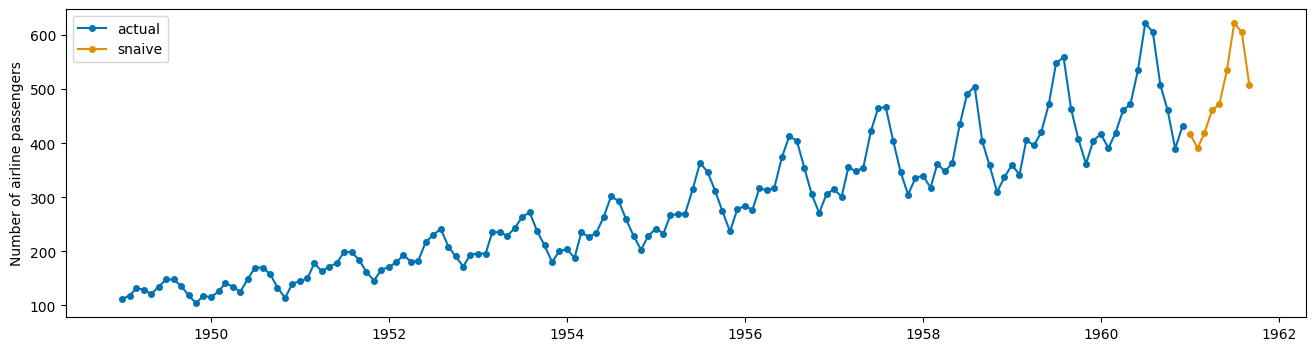

In [5]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_snaive_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_snaive_pred, labels=["actual", "snaive"])

### II.2.D. Drift method

The drift method is a variation of the naive method that allows the forecast to increase or decrease over time.

$$\hat{y}_t = y_{t-1} + \frac{y_{t-1} - y_{t-k}}{k}
$$where $k$ is the number of periods over which the drift is calculated.

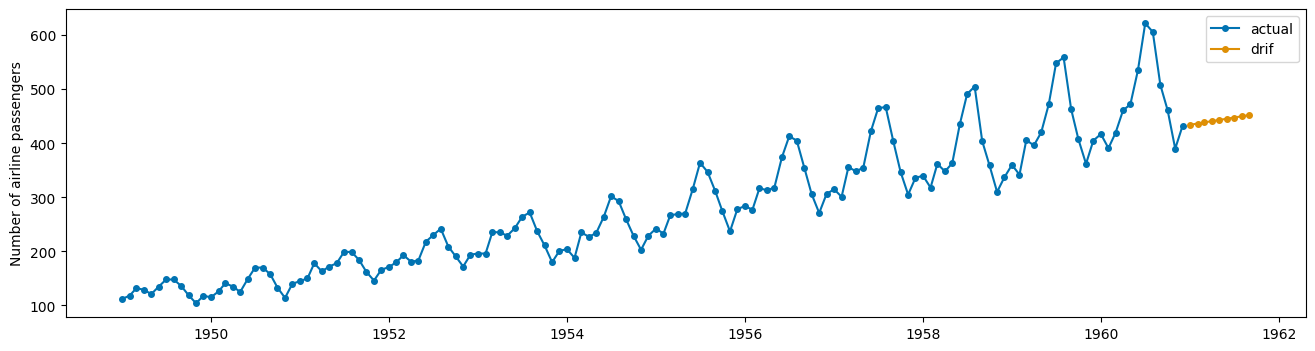

In [6]:
y = load_airline()

# `k` would be regulated via `window_length` parameter
forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(y)

fh = ForecastingHorizon(values=range(1,10), is_relative=True)
y_drift_pred = forecaster.predict(fh)

fig, ax = plot_series(y, y_drift_pred, labels=["actual", "drif"])

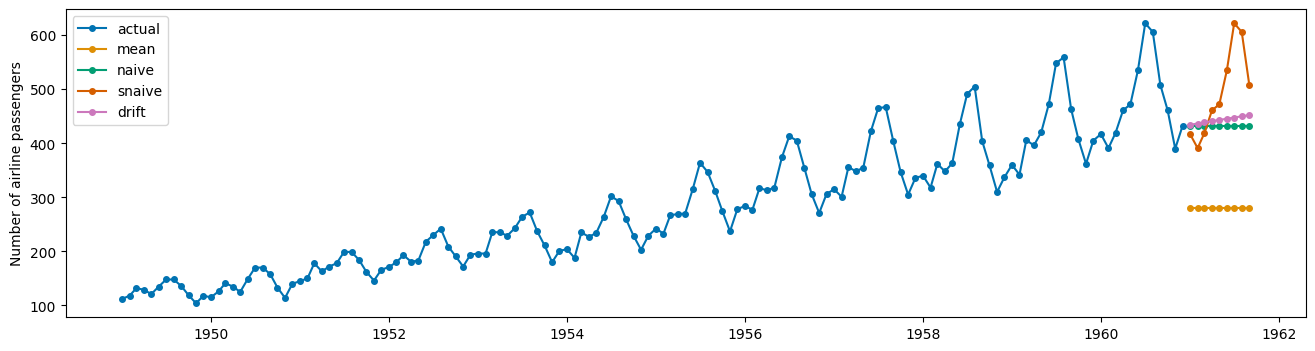

In [7]:
series = [y, y_mean_pred, y_naive_pred, y_snaive_pred, y_drift_pred]
labels = ["actual", "mean", "naive", "snaive", "drift"]
fig, ax = plot_series(*series, labels=labels)

### II.2.E Forecast error

The forecast error ($e_t$) is the difference between the actual value ($y_t$) and the forecast value ($\hat{y}_t$):

$$
e_t = y_t - \hat{y}_t
$$

Residuals are useful in checking whether a model has adequately captured the information in the data.

A good forecasting method will yield residuals with the following properties:

- The **residuals are uncorrelated**. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

- The **residuals have zero mean**. If the residuals have a mean other than zero, then the forecasts are biased.

In [8]:
from utils import plot_residuals

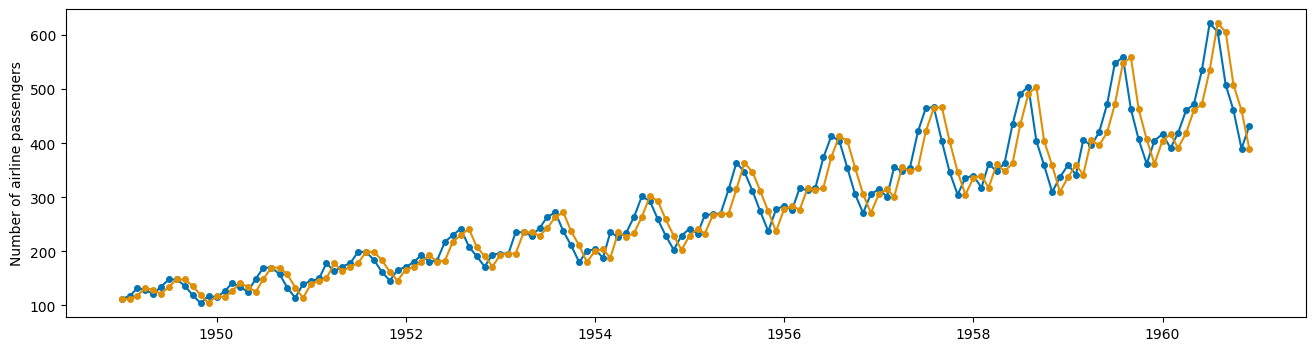

In [9]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y)

# Forecast for the entire historical period
fh = ForecastingHorizon(y.index, is_relative=False)
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y,y_pred)

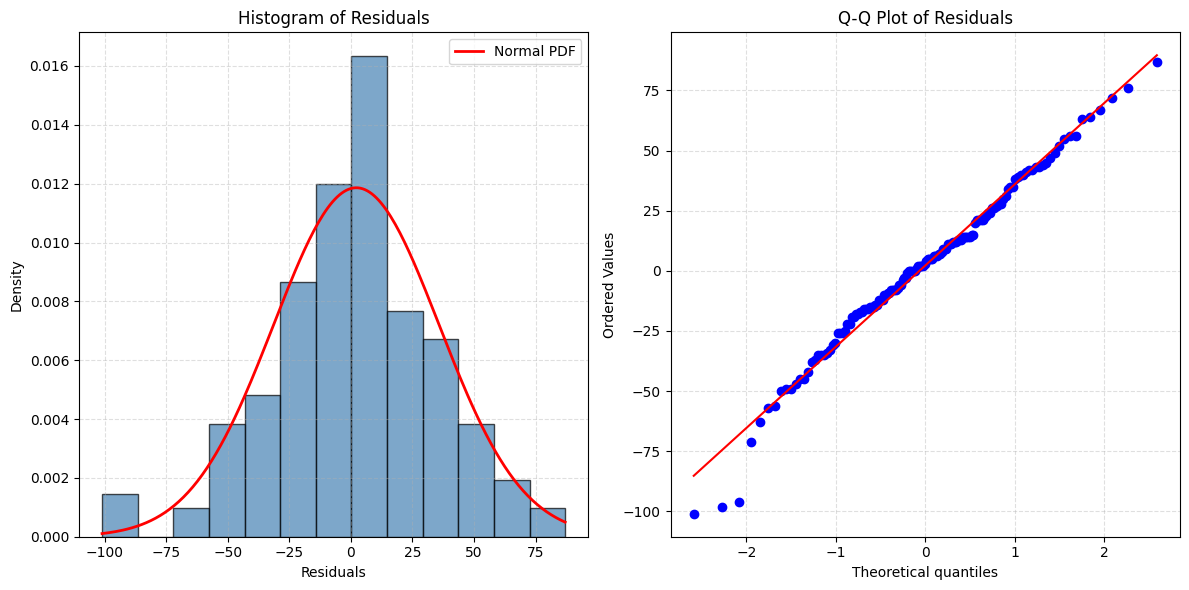

In [10]:
residuals = y - y_pred
plot_residuals(residuals)

### Assessing normality of residuals: Visual criteria

Normality of residuals is an important assumption for some time series analyses. Visual methods help to quickly assess deviations from normality.

**Histogram:**

   -   **Symmetry:** The histogram should be approximately symmetric, resembling a bell curve.
   -   **Skewness:**
        -   Right-skewed (long tail to the right): Indicates more smaller residuals.
        -   Left-skewed (long tail to the left): Indicates more larger residuals.
   -   **Kurtosis:**
        -   Mesokurtic: Similar tail behavior to a normal distribution.
        -   Leptokurtic: Heavier tails (more extreme residual values).
        -   Platykurtic: Lighter tails (fewer extreme residual values).
   -   **Normal Curve Fit:** Compare the histogram's shape to an overlaid normal distribution curve; a close fit suggests normality.

**Q-Q Plot (Quantile-Quantile Plot):**

   -   **Linearity:** Residuals should fall closely along the straight diagonal line.
   -   **Deviations:**
        -   End deviations: Indicate non-normality in the distribution's tails (skewness/kurtosis).
        -   Curvature: Suggests skewness.
        -   S-shape: Often indicates skewness.

**Note**: Perfect normality is rare in practice. The severity of deviations and their impact on the analysis should be considered.

**General guideline**: Minor wiggles around the line in a `Q-Q plot are common, especially with smaller sample sizes. Focus on systematic and significant deviations. The Q-Q plot is often considered a more reliable visual tool for assessing normality than a histogram, particularly for detecting deviations in the tails.

### II.2.F Bootstrapping for uncertainty estimation

Bootstrapping is a resampling technique used to estimate the uncertainty of forecasts. It provides a way to generate prediction intervals without relying on strong distributional assumptions about the residuals.

The process involves:

1.  Fitting a forecasting model to the historical time series data.

2.  Calculating the residuals.

3.  Repeatedly resampling the residuals with replacement to create multiple **bootstrapped** residual sets.

4.  For each bootstrapped residual set, generating a new set of forecasts by adding the resampled residuals to the model's point forecasts.

5.  Calculating statistics (e.g., quantiles) across the bootstrapped forecasts to estimate prediction intervals.

In [11]:
from utils import bootstrapped_forecasts, plot_forecast_with_intervals

In [12]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last", sp=10)
forecaster.fit(y)

# Forecast for the entire historical period
fh = ForecastingHorizon(range(1,20))  

y_pred, boot_preds = bootstrapped_forecasts(forecaster, y, fh)

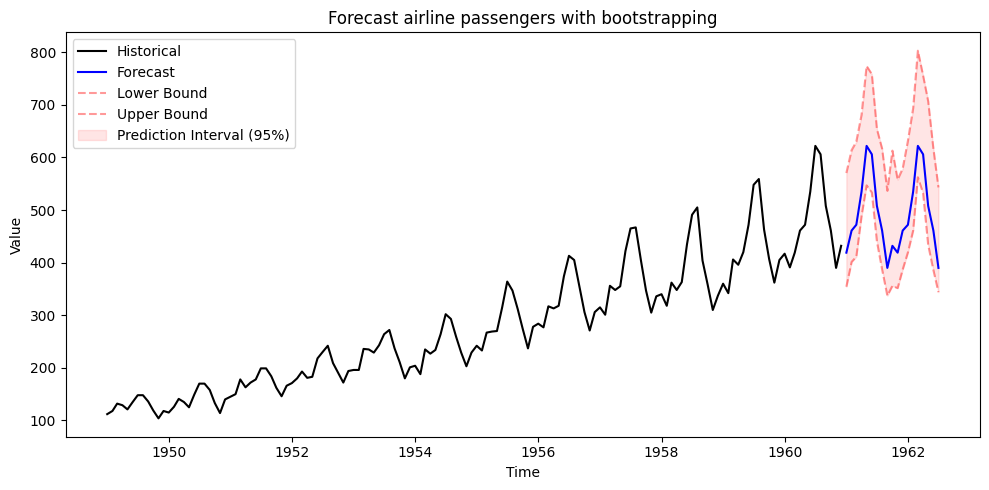

In [13]:
plot_forecast_with_intervals(
    actual=y,
    forecast=y_pred,
    lower=boot_preds.quantile(0.025, axis=1),
    upper=boot_preds.quantile(0.975, axis=1),
    title="Forecast airline passengers with bootstrapping"
)

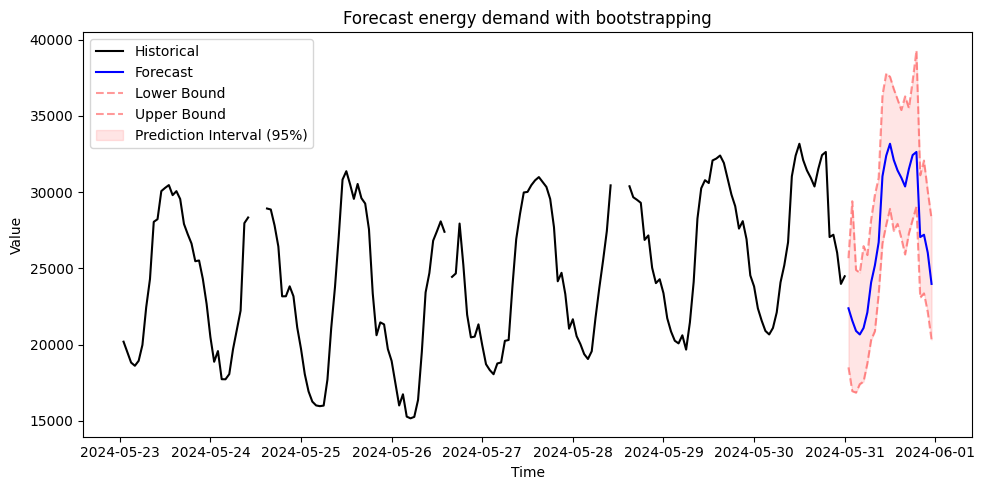

In [14]:
y = energy_month["energy"].asfreq("h")

forecaster = NaiveForecaster(strategy="last", sp=24)
forecaster.fit(y)

fh = ForecastingHorizon(range(1,24), is_relative=True)

y_pred, boot_preds = bootstrapped_forecasts(forecaster, y, fh)


plot_forecast_with_intervals(
    actual=y[-24*8:],
    forecast=y_pred,
    lower=boot_preds.quantile(0.025, axis=1),
    upper=boot_preds.quantile(0.975, axis=1),
    title="Forecast energy demand with bootstrapping"
)

In [15]:
import matplotlib.pyplot as plt

from sktime.datasets import load_airline 
from sktime.utils.plotting import plot_correlations, plot_series
from sktime.transformations.series.detrend import MSTL

years = np.arange(1, 125)
index = pd.date_range(start='1900-01-01', periods=len(years), freq='YS')

# Generate the seasonal component
seasonal = pd.Series((-11 * np.sin(years / 12 * 2 * np.pi) +
            5.7 * np.sin(years / 12 * 4 * np.pi) -
            2 * np.sin(years / 12 * 6 * np.pi) +
            2.5 * np.sin(years / 12 * 8 * np.pi) +
            1.6 * np.sin(years / 12 * 10 * np.pi)), index=index)

# Generate the trend component
trend = pd.Series(40000 - (years - 1)**2, index=index)

# Generate the noise component
noise = pd.Series(np.random.normal(0, 1000, len(years)), index=index)

# Combine the components to create the time series
y = trend + seasonal + noise

# Create a Pandas Series with a DatetimeIndex
X = pd.Series(y, index=index)

X.plot()
plt.tight_layout()
plt.show()

seasonal[-25:].plot()
plt.tight_layout()
plt.show()

mstl = MSTL(return_components=True, periods=[12], windows=13) 
mstl.fit(X)

decomposition = mstl.transform(X)

decomposition.plot()
plt.tight_layout()

mstl_trafo = MSTL(return_components=True, periods=[12], windows=13) 

X = load_airline()
X.index = X.index.to_timestamp()

res = mstl_trafo.fit_transform(X)
res.plot()

X_log = np.log(X)
res = mstl_trafo.fit_transform(X_log)
res.plot()

from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import MSTL
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.compose import TransformedTargetForecaster

# Create a forecasting pipeline: MSTL for deseasonalization followed by TrendForecaster
mstl_deseason_fcst = mstl_trafo * TrendForecaster()

# Fit the forecasting pipeline to the data, forecasting horizons [1, 2, 3]
mstl_deseason_fcst.fit(X, fh=range(1,31))

# Make predictions
y_pred = mstl_deseason_fcst.predict()

from sktime.utils.plotting import plot_series

plot_series(X, y_pred)

NameError: name 'np' is not defined